<a href="https://colab.research.google.com/github/ashnar05/two-compartment-antibody/blob/main/Ashna_Ramaswamy_Lab_4_BE_5570.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BE5570 Lab 4
### Due: 12/2/2024 at 11:59PM, via submission on Canvas
### 100 pts total




**Add Your Info Here:**

>  Name: Ashna Ramaswamy        \
>  PID: 28536702         \
>  Notes for TA (collaborators, technical problems, etc): Group 7

In today's lab, you will be developing a quantitative understanding antibody distribution in a two-compartment model of blood and tumor tissue. Please refer to you all your lecture notes, particularly those on Krogh's cylinder in Lecture 19 for help with this assignment.

**Pre-Lab Questions: (2pts each)**

1.   What is Cetuximab? What is its target? What indications is it used for?

Cetuximab is an IgG1 antibody (a chimeric monoclonal antibody) which targets and inhibits the epidermal growth factor receptor (EGFR), which is indicated in cell survival, proliferation, angiogenesis, and differentiation. It does this by blocking the binding of its natural ligands (EGF and TGF-a) and preventing downstream signaling. It's used to treat metastatic colorectal cancer (mCRC) and head and neck cell carcinoma (HNSCC).

2.   Describe two different "elimination" mechanisms for Cetuximab in the body.

a) Receptor-mediated endocytosis -- Cetuximab binds to EGFR on cell surfaces, leading to internalization and degradation of the receptor-antibody complex in lysosomes.

b) Fc-mediated clearance -- The Fc region of Cetuximab interacts with Fc gamma receptors on immune cells, such as macrophages or natural killer cells. This can lead to antibody-dependent cellular phagocytosis or lysosomal degradation. Also, the reticuloendothelial system can catalyze Cetuximab into amino acids.

3.   What is the significance of tumor EGFR receptor levels in determining Cetuximab efficacy?

Higher levels of EGFR in the tumor corresponds with improved drug efficacy of Cetuximab as there are more receptors available to bind to the drug, increasing the possible number of interactions/the probability of binding. Lower levels can result in reduced efficiency.

4.   Name a common side effect of Cetuximab that arises from off-tumor tissue on-target uptake of this drug.

A rash called an acneiform rash can occur, because EGFR is expressed on keratinocytes in the skin to regulate proliferation. Since Cetuximab binds to EGFR, binding in this region can lead to skin irritation/inflammation, and skin barrier disruption.

5. What is the significance of void fraction in tumor drug delivery?

The void fraction is the proportion or fraction of extracellular space within the interstitium of the tumor that is accessible to interface with a drug. It's important as a higher fraction results in better distribution and diffusion of the drug in the tumor microenvironment due to a larger surface area available to the tumor, which improves efficacy. Lower fractions results in high interstitial pressure and a dense ECM, so the drug can't adequately diffuse throughout the tumor, affecting its concentration levels at the tumor cells.

In [ ]:
# import packages
!apt-get install -y ffmpeg
import numpy as np
import matplotlib.pyplot as plt
import math
%config InlineBackend.figure_format='retina'
import time
from scipy import stats
import scipy.integrate
from scipy.integrate import solve_ivp
from scipy.integrate import simpson
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline
import seaborn as sns # pip install seaborn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


__________________
 A quantitative understanding of how antibodies are distributed across the body  can illustrate which features and processing steps most influence drug delivery, thus aiding in designing and dosing of effective antibodies. In this project, we will develop a physiologically-based pharmacokinetic (PBPK) model for cetuximab distribution in a mouse and use empirically collected data to parameterize this model. This model will highlight the direct relationship between dose, affinity and target saturation in the tumor.

 For this kinetic model, first consider the following processes involving Cetuximab: 1) transport between blood/tumor 2) target-mediated clearance, which entails tumor cell receptor binding, internalization, and degradation.  NOTE: we do NOT have to account for tumor cell growth in this experiment or the process of Cetuximab-induced cell death or growth inhibition.

 Based on the above list processes, **complete the following binding equations.** Be sure to clearly delinate Antibody in different compartments and states in your text (for example, antibody in plasma [Ab_p] vs free antibody in the tumor [Ab_tf], receptor-bound antibody in the tumor [Ab-tb]).  Please give both forward and reverse rates different numbers (for example, k1 and k2 instead of k1 and k-1). **(3pts each)**






**Variables**
*   P = permeability
*   R_cap = Radius of capillary
*   R_k = Radius of Krogh cylinder
*   e = void fration
*   V_t = tumor volume
*   V_p = plasma volume
*   k_clearance = clearance of antibody in serum
*   k_e = clearance of bound receptor
*   k_int = internalziation of unbound receptor
*   k_synthesis = synthesis of EGFR receptor
*   k_on = forward/binding rate of drug to receptor
*   k_off = reverse rate constant

**d_Ab_p** = ( 2 * P * R_cap ) / (R_k)^2 * (( Ab_tf / e - Ab_p )) * (( V_t * e ) / V_p )  - ( k_clearance * Ab_p )

**d_Ab_tf** = ( 2 * P * R_cap ) / (R_k)^2 * ( e * Ab_p - Ab_tf ) - (( kon * Ag * Ab_tf/e )) + ( k_off * Ab_tb )

**d_Ab_tb** = k_on * ( Ab_tf * Ag / e) - ( Ab_tb  * (k_off + k_e + k_int))

**d_Ag** = - ( k_on * Ag * Ab_tf / e) + ( k_off * Ab_tb ) - ( k_int * Ag ) + k_synthesis

**Based on the following information, solve for the equation constants (1pt each)**
*   The kon of Cetuximab for EGFR receptor is  2E5 1/M/s. The dissociation constant (or Kd) for Cetuximab for EGFR is 0.5 nM.
*   Cetuximab has a molecular weight of 150 kDa, which is typical for an antibody. It also has a permeability coefficient and a void volume or tumor accessibility typical for an average antibody. (See lecture Notes for these values)
*   In a high-EGFR-expressing tumor cell line, we measured around 5E5 EGFR molecules per tumor cell. We begin to treat this subcutaneous tumor when it reaches 100 cubic millimeters, which we approximate contains around 10 million tumor cells. Based on isotope tracing experiments done with this tumor cell line, nascent EGFR are synthesized at a rate of 150 new molecules per minute per cell.
*   For this tumor cell line, we measured Cetuximab's half-lives for net internalization as 2.5 hours.
*   The circulating blood volume of a mouse is 2 mL. The serum half-life of cetuximab is 38 hours.

IMPORTANT NOTE: although we have listed constants in the code outline as k, not all of them are rates.

We will be simulating the movement of single tail-vein injection of Cetuximab in a mouse bearing a tumor, starting by injecting 30 ug of Cetuximab. **Use this  information to solve for initial conditions (1pt each)**

In [ ]:
#Constants #molar and liters

k1 = 2e5 # association rate constant kon, 1/M/s
k2 = 2e5 * 0.5e-9 # dissociation rate constant koff, 1/s
k4 = 2.8e-9 # permeability P, m/s
k5 = 0.24 # void fraction epsilon, no units
k6 = ( np.log(2) / (2.5 * 3600) ) # internalization/endocytosis of bound EGFR receptor k_e, 1/s
k7 = ( np.log(2) / (38 * 3600) ) # clearance of antibody in serum k_clearance, 1/s
k9 = 75e-6 # radius of Krogh cylinder R_Krogh, m
k10 = 8e-6 # radius of capillary R_cap, m
k12 = 2e-3 # blood volume V_p, L
k13 = 100 * 0.001 ** 3 * 1000 # tumor volume V_t, L
k8 = 150 / ( 60 * 5e5 ) # internalization of unbound receptor k_int, 1/s
k11 = (5e5 * 10e6) / (k13 * 6.022e23) # EGFR receptor in tumor Ag, mol
k3 = ( 150 * 10e6 ) / (k13 * 6.022e23 * 60) # synthesis of EGFR receptor k_synthesis, mol/m^3/s

#Initial Conditions
Ab_p = ( 30e-6 / 150e3 ) / k12 # concentration of free cetuximab antibody in plasma, M
Ab_tf = 0 # concentration of free cetuximab antibody in tumor interstitium, M
Ab_tb = 0 # concentration of bound cetuximab antibody in tumor interstitium, M
Ag = ( 5e5 * 10e6 ) / ( k13 * 6.022e23 ) # concentration of EGFR receptor (antigen) molecules in the tumor, M

print("k1 / Association rate constant / k_on = {:.2e} 1/M/s".format(k1))
print("k2 / Dissociation rate constant / k_off = {:.2e} 1/s".format(k2))
print("k3 / Rate of synthesis of EGFR receptor / k_synthesis = {:.2e} mol/m^3/s".format(k3))
print("k4 / Permeability / P = {:.2e} m/s".format(k4))
print("k5 / Void fraction / epsilon (e) = {:.2e}".format(k5))
print("k6 / Internalization/endocytosis of bound EGFR / k_e = {:.2e} 1/s".format(k6))
print("k7 / Clearance of antibody in serum / k_clearance = {:.2e} 1/s".format(k7))
print("k8 / Internalization of unbound receptor / k_int = {:.2e} 1/s".format(k8))
print("k9 / Radius of Krogh cylinder / R_Krogh = {:.2e} m".format(k9))
print("k10 / Radius of capillary / R_cap = {:.2e} m".format(k10))
print("k11 / Moles of EGFR in tumor / Ag = {:.2e} mol".format(k11))
print("k12 / Volume of blood / V_p = {:.2e} L".format(k12))
print("k13 / Volume of tumor / V_t = {:.2e} L".format(k13))

print("\nInitial conditions")
print("Ab_p / Free Ab in plasma [Ab_p] = {:.2e} M".format(Ab_p))
print("Ab_tf / Free Ab in tumor [Ab_tf] = {:.2e} M".format(Ab_tf))
print("Ab_tb / Bound Ab to EGFR receptor in tumor [Ab_tb] = {:.2e} M".format(Ab_tb))
print("Ag / EGFR Receptor [Ag] = {:.2e} M".format(Ag))

k1 / Association rate constant / k_on = 2.00e+05 1/M/s
k2 / Dissociation rate constant / k_off = 1.00e-04 1/s
k3 / Rate of synthesis of EGFR receptor / k_synthesis = 4.15e-13 mol/m^3/s
k4 / Permeability / P = 2.80e-09 m/s
k5 / Void fraction / epsilon (e) = 2.40e-01
k6 / Internalization/endocytosis of bound EGFR / k_e = 7.70e-05 1/s
k7 / Clearance of antibody in serum / k_clearance = 5.07e-06 1/s
k8 / Internalization of unbound receptor / k_int = 5.00e-06 1/s
k9 / Radius of Krogh cylinder / R_Krogh = 7.50e-05 m
k10 / Radius of capillary / R_cap = 8.00e-06 m
k11 / Moles of EGFR in tumor / Ag = 8.30e-08 mol
k12 / Volume of blood / V_p = 2.00e-03 L
k13 / Volume of tumor / V_t = 1.00e-04 L

Initial conditions
Ab_p / Free Ab in plasma [Ab_p] = 1.00e-07 M
Ab_tf / Free Ab in tumor [Ab_tf] = 0.00e+00 M
Ab_tb / Bound Ab to EGFR receptor in tumor [Ab_tb] = 0.00e+00 M
Ag / EGFR Receptor [Ag] = 8.30e-08 M


Next, define a solver and simulate binding over the course of three days. **(15 pts)**

In [ ]:
# Setting up differential equations
def sys(t, vec):
  Ab_p, Ab_tf, Ab_tb, Ag = vec

  d_Ab_p = (( 2 * k4 * k10 ) * (( Ab_tf / k5 - Ab_p )) * (( k13 * k5 ) / k12 ) / ( k9 )**2 )  - ( k7 * Ab_p )
  d_Ab_tf = (( 2 * k4 * k10 ) * (( k5 * Ab_p ) - Ab_tf ) / ( k9 )**2 ) - (( k1 * ( Ab_tf * Ag )) / k5 ) + ( k2 * Ab_tb )
  d_Ab_tb = (( k1 * ( Ab_tf * Ag )) / k5) - ( Ab_tb  * (k2 + k6 + k8))
  d_Ag =  - (( k1 * ( Ab_tf * Ag )) / k5) + ( k2 * Ab_tb ) + k3 - ( k8 * Ag )

  sys_vec = [d_Ab_p, d_Ab_tf, d_Ab_tb, d_Ag]
  return sys_vec

In [ ]:
# Setting up initial conditions and time span
initial = [Ab_p, Ab_tf, Ab_tb, Ag]
t_span = (0, 72 * 3600) # 3 days converted to seconds
t = np.linspace(t_span[0], t_span[1], 1000)

# Solving ODEs with a solver function
def solve_sys(initial, t):
  solution = scipy.integrate.solve_ivp(sys, t_span = (t[0], t[-1]), y0 = initial, t_eval = None, atol = 1e-14, rtol = 1e-14, method = 'BDF')
  return solution

sol = solve_sys(initial, t)

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Now, plot your model solution. Be sure to include the values of all possible version of cetuximab (Ab_p, Ab_tf, Ab_tb) and EGFR (Ag) in the tumor. Ensure your plot contains axes labels and a title. **(8 pts)**

 Note: Antibody and antigen tissue concentrations are restricted to the extracellular tissue volume, which results in higher interstitial versus overall drug concentration. This increase in concentration is accounted for by dividing the concentration values by the void fraction. Please display the **interstitial** concentration of Ab_tf, Ab_tb and Ag.

Text(0, 0.5, 'Total Concentration (M)')

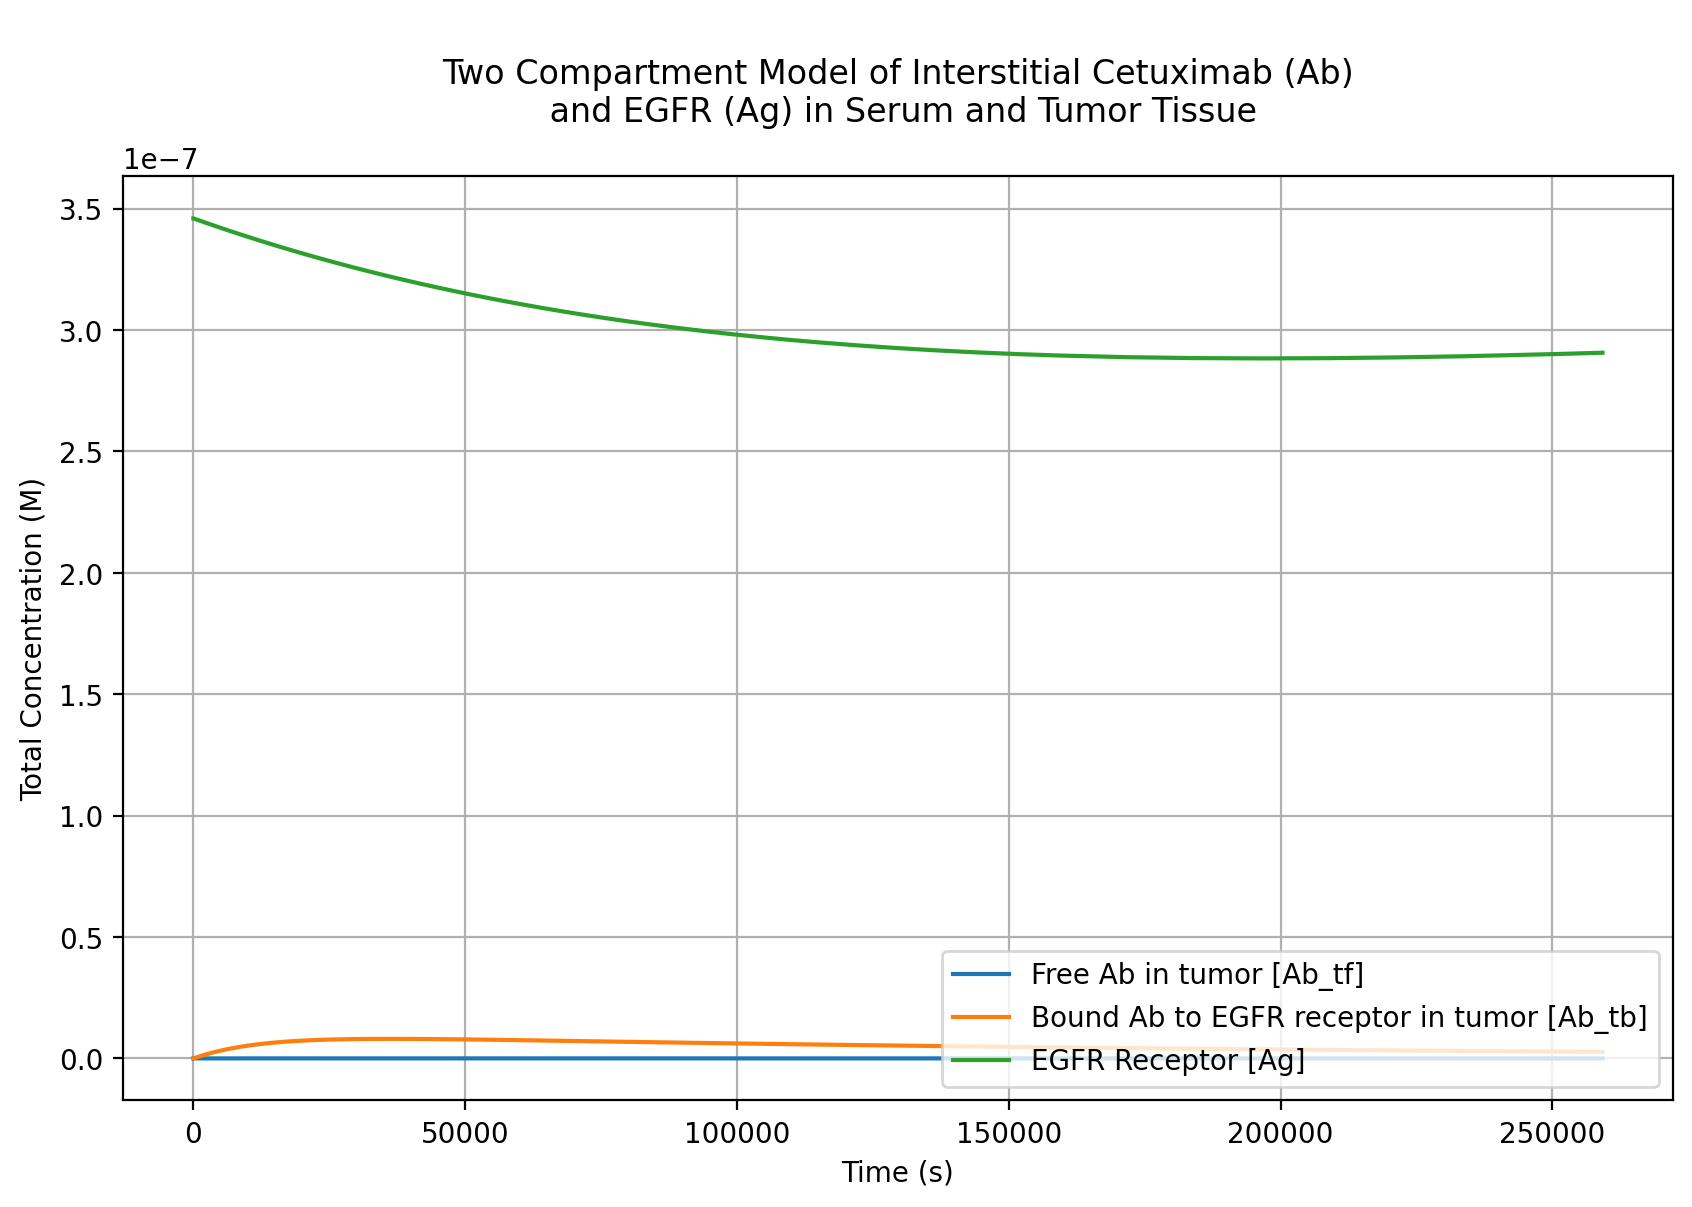

In [ ]:
# Solutions
# Note: Ab_tf, Ab_tb, and Ag are divided by the void fraction to account for the interstitial concentration
Ab_p_pop = sol.y[0]
Ab_tf_pop = sol.y[1]/k5
Ab_tb_pop = sol.y[2]/k5
Ag_pop = sol.y[3]/k5
t = sol.t

plt.figure(figsize = (10,6))
#plt.plot(t, Ab_p_pop, label = "Free Ab in plasma [Ab_p]")
plt.plot(t, Ab_tf_pop, label = "Free Ab in tumor [Ab_tf]")
plt.plot(t, Ab_tb_pop, label = "Bound Ab to EGFR receptor in tumor [Ab_tb]")
plt.plot(t, Ag_pop, label = "EGFR Receptor [Ag]")

plt.legend(loc="lower right")
plt.grid(True, which='both')
plt.title("\nTwo Compartment Model of Interstitial Cetuximab (Ab)\n and EGFR (Ag) in Serum and Tumor Tissue\n")
plt.xlabel("Time (s)")
plt.ylabel("Total Concentration (M)")

**Results Questions (3pts each)**

1) Is this dose sufficient to saturate all tumor EGFR? If not, what is the minimum amount of Cetuximab that should be administered in a single dose to saturate all tumor EGFR over 3 days?

No, because there is a significantly higher concentration of tumor EGFR (Ag) than there are bound Cetuximab to the EGFRs (Ab_tb) showing that the Ag is not saturated. As such, the amount of Ab must equal the amount of Ag to saturate the receptors, so the minimum dose would likely be 300ug (10x the current dosage).

2) How might including cetuximab-induced cell death in this model change the outcome? (You do not need to provide code for this answer, just explain your reasoning).

Including cell death induced by Cetuximab would result in a decrease in the tumor cell population, which subsequently reduces the Ag population. This results in a closer concentration of Ab_tb to Ag, increasing drug efficiency and distribution throughout the tumor.

**Alternative Dosing Strategies (17pts)**

In our first simulation, we were restricted in dosing with one single injection. It is more common to achieve therapeutic efficacy by redosing  multiple times. Here, you will identify how antibody distribution would change with more frequent dosing. Your model output graphic should show all possible configurations of antibody (Ab_p, Ab_tf, Ab_tb), for a dosing regimen of 30 ug of Cetuximab given every 3 days, for a total of 4 injections across 10 days. **Please ensure your code is properly commented for accurate grading**

In [ ]:
#Constants

k1 = 2e5 # association rate constant kon, 1/M/s
k2 = 2e5 * 0.5e-9 # dissociation rate constant koff, 1/s
k4 = 2.8e-9 # permeability P, m/s
k5 = 0.24 # void fraction epsilon, no units
k6 = ( np.log(2) / (2.5 * 3600) ) # internalization/endocytosis of bound EGFR receptor k_e, 1/s
k7 = ( np.log(2) / (38 * 3600) ) # clearance of antibody in serum k_clearance, 1/s
k9 = 75e-6 # radius of Krogh cylinder R_Krogh, m
k10 = 8e-6 # radius of capillary R_cap, m
k12 = 2e-3 # blood volume V_p, L
k13 = 100 * 0.001 ** 3 * 1000 # tumor volume V_t, L
k8 = 150 / ( 60 * 5e5 ) # internalization of unbound receptor k_int, 1/s
k11 = (5e5 * 10e6) / (k13 * 6.022e23) # EGFR receptor in tumor Ag, mol
k3 = ( 150 * 10e6 ) / (k13 * 6.022e23 * 60) # synthesis of EGFR receptor k_synthesis, mol/m^3/s

#Initial Conditions
Ab_p = ( 30e-6 / 150e3 ) / k12 # concentration of free cetuximab antibody in plasma, M
Ab_tf = 0 # concentration of free cetuximab antibody in tumor interstitium, M
Ab_tb = 0 # concentration of bound cetuximab antibody in tumor interstitium, M
Ag = ( 5e5 * 10e6 ) / ( k13 * 6.022e23 ) # concentration of EGFR receptor (antigen) molecules in the tumor, M

duration = 10 * 24 * 3600 # 10 days converted to seconds
injection_interval = 72 * 3600 # 3 days in seconds
number_of_injections = 4
dosage = Ab_p

def sys(t, vec):
  Ab_p, Ab_tf, Ab_tb, Ag = vec

  d_Ab_p = (( 2 * k4 * k10 ) * (( Ab_tf / k5 - Ab_p )) * (( k13 * k5 ) / k12 ) / ( k9 )**2 )  - ( k7 * Ab_p )
  d_Ab_tf = (( 2 * k4 * k10 ) * (( k5 * Ab_p ) - Ab_tf ) / ( k9 )**2 ) - (( k1 * ( Ab_tf * Ag )) / k5 ) + ( k2 * Ab_tb )
  d_Ab_tb = (( k1 * ( Ab_tf * Ag )) / k5) - ( Ab_tb  * (k2 + k6 + k8))
  d_Ag =  - (( k1 * ( Ab_tf * Ag )) / k5) + ( k2 * Ab_tb ) + k3 - ( k8 * Ag )

  sys_vec = [d_Ab_p, d_Ab_tf, d_Ab_tb, d_Ag]
  return sys_vec

initial = [Ab_p, Ab_tf, Ab_tb, Ag]
time = []
conc = []

# Looping through each dose from an injection
n = 0
for i in range(number_of_injections):
  # Time span and intervals
  t_span = (n, min(n + injection_interval, duration))
  t = np.linspace(t_span[0], t_span[1], 1000)
  # Solver
  sol2 = solve_sys(initial, t)
  # Adding values of time and concentrations to lists
  time.extend(sol2.t)
  conc.append(sol2.y)
  # Updating timestep
  n = t_span[1]
  # Updating initial conditions
  initial = sol2.y[:,-1]
  # Adding Ab_p dose to blood
  initial[0] += dosage

# Organizing data according to variable
Ab_p_pop2 = np.concatenate([i[0] for i in conc])
Ab_tf_pop2 = np.concatenate([i[1]/k5 for i in conc])
Ab_tb_pop2 = np.concatenate([i[2]/k5 for i in conc])
Ag_pop2 = np.concatenate([i[3]/k5 for i in conc])
t2 = np.array(time)

Plot your results:

Text(0, 0.5, 'Total Concentration (M)')

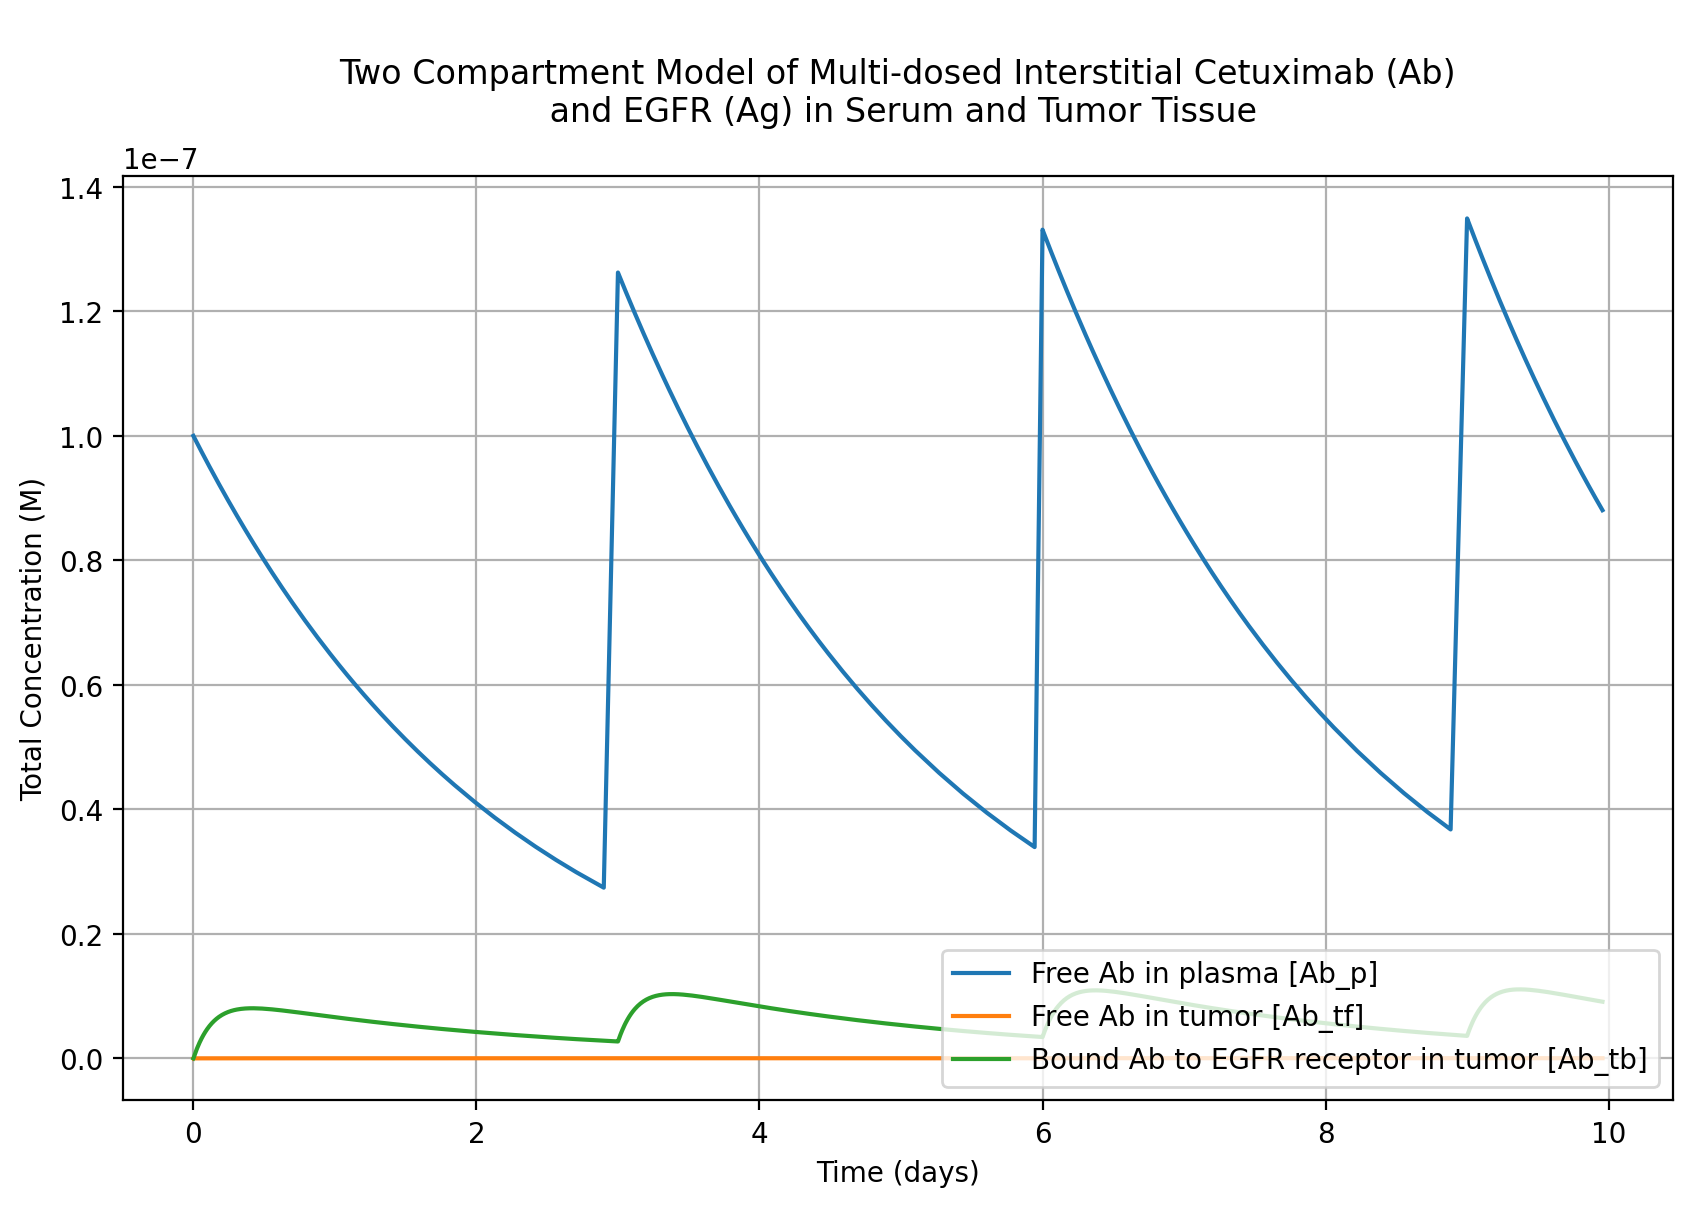

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(t2[:-1] / 86400, Ab_p_pop2[:-1], label = "Free Ab in plasma [Ab_p]")
plt.plot(t2[:-1] / 86400, Ab_tf_pop2[:-1], label = "Free Ab in tumor [Ab_tf]")
plt.plot(t2[:-1] / 86400, Ab_tb_pop2[:-1], label = "Bound Ab to EGFR receptor in tumor [Ab_tb]")
#plt.plot(t2[:-1] / 86400, Ag_pop2[:-1], label = "EGFR Receptor [Ag]")

plt.legend(loc="lower right")
plt.grid(True, which='both')
plt.title("\nTwo Compartment Model of Multi-dosed Interstitial Cetuximab (Ab)\n and EGFR (Ag) in Serum and Tumor Tissue\n")
plt.xlabel("Time (days)")
plt.ylabel("Total Concentration (M)")

**Discussion Questions**

1. Is this dosing schedule sufficient to saturate all tumor EGFR? Why or why not? **(3pts)**

It is still insufficient as the Ab_tb is low, and if we compare the concentrations to the concentration of Ag in the previous graph, it is significantly smaller even with the small spikes of Ab_tb from the additional doses.

2. We'd like for you to consider other  other features of Cetuximab that could you change to improve the tumor saturation: **(9pts)** \
  a.  How does decreasing koff 10x (i.e. equivalent to decreasing Kd which implies improving the affinity) impact saturation? \

  Since decreasing the koff results in decreasing the Kd and consequently improving the affinity, this would result in a higher concentration of Ab_tb due to the higher affinity, resulting in better/higher saturation.

  b. How does increasing the internalization half-life time by 10x impact saturation? \

  This would increase the time it takes for the Cetuximab-EGFR complex (Ab_tb) to be internalized, which means that binding would be prolonged and the antibody wouldn't be cleared as rapidly, improving saturation.

  c. How does increasing the clearance half-life time by 10x impact saturation? \

  This would slow down the rate at which Cetuximab is cleared, thus allowing it to circulate/diffuse for longer, which results in a more sustained concentration of available Cetuximab for binding to EGFR, thus increasing saturation.


3. How could the model be made more physiologically relevant? List at least three possible changes. **(3pts)**

We could include three important variables: \
1) Including Cetuximab-induced cell death would show how effectively the drug kills the tumor cells, which is the desired outcome to model. This would also impact pharmacokinetics in terms of saturation. \
2) Add a term/behavior for the variation of EGFR expression in tumor cells. This is relevant because tumor cells can have different mutagenic events within one tumor which results in spatial heterogeneity and is often a barrier to treatment success. \
3) Pressure within the interstitial space would be physiologically relevant,since this can disturb drug influx and distribution. Alternatively, we could vary the void fraction. This is relevant since some regions of the tumor can be denser than others according to the location of the tumor and EGFR distribution/expression levels. \

**Bonus Questions (2pts each)**
1. Name at least four parameters that must be considered when determining patient dosing schedules in the clinic, and explain your reasoning for each.

1) Body weight/BMI/surface area: It's important to account for these weight-related factors as differences in weight can alter dosing concentrations and affect clinical outcomes. \
2) Immunological activity of the patient: A patient with an immune disorder/dysfunction due to cancer can affect the response to an immunologic agent. There may also be off-target/side effects. \
3) Tumor size/density: This would affect drug distribution and saturation of EGFR receptors, so dosing needs to be adjusted. \
4) EGFR expression and distribution: This is especially important when comparing saturation levels and finding the minimal effective dose without risking adverse reactions. Higher concentrations would require higher doses, and lower concentrations would require lower doses to adequately saturate the receptors while avoiding compromising the health of the patient. \

2. Which cancer types generally make "denser" tumors? How might that affect the tumor void fraction and antibody penetration? Explain your reasoning.

Breast cancers, colon cancers, and pancreatic cancers have a strong fibrotic and/or stromal component, which result in denser tumors. This reduces the void fraction because denser tissue acts as a physical barrier to large-molecule drugs like antibodies, and interstitial pressure is higher than normal, affecting drug influx. Dense tumors also often have a heterogeneous distribution of receptors, making it difficult for a drug to access them. As such, dense tumors decrease drug efficacy and antibody penetration.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

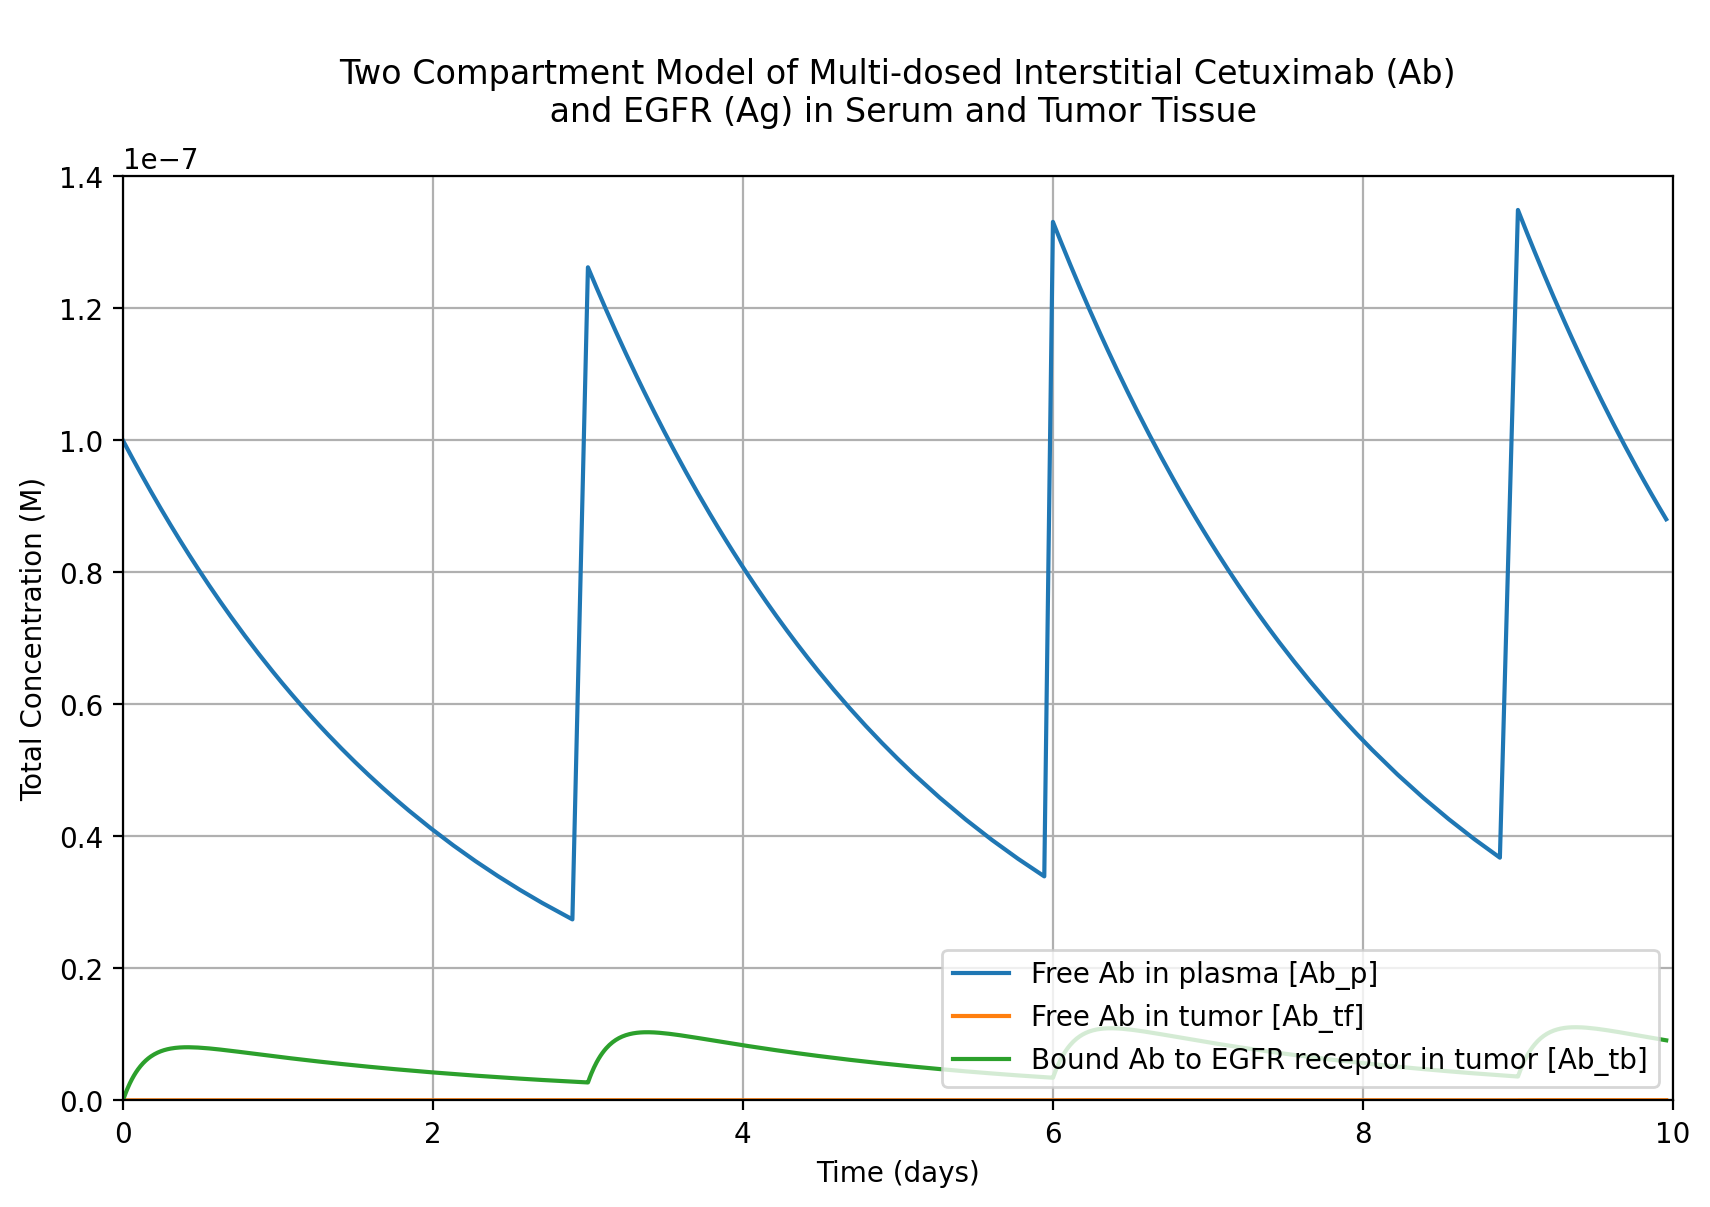

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
line1, = ax.plot([], [], label="Free Ab in plasma [Ab_p]")
line2, = ax.plot([], [], label="Free Ab in tumor [Ab_tf]")
line3, = ax.plot([], [], label="Bound Ab to EGFR receptor in tumor [Ab_tb]")

ax.set_xlim(t2[0]/86400, t2[-1]/86400)
ymin = min(np.min(Ab_p_pop2), np.min(Ab_tf_pop2), np.min(Ab_tb_pop2))
ymax = 1.4e-7
ax.set_ylim(ymin, ymax)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Total Concentration (M)")
ax.set_title("\nTwo Compartment Model of Multi-dosed Interstitial Cetuximab (Ab)\n and EGFR (Ag) in Serum and Tumor Tissue\n")
ax.legend(loc="lower right")
ax.grid(True, which='both')

# Initialization function
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3

# Animation function
def animate(i):
    x = t2[:i] / 86400
    line1.set_data(x, Ab_p_pop2[:i])
    line2.set_data(x, Ab_tf_pop2[:i])
    line3.set_data(x, Ab_tb_pop2[:i])
    return line1, line2, line3

# Create the animation
frames = len(t2)
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=frames, interval=50, blit=True)

# Display
HTML(anim.to_jshtml())

# Save the animation as an MP4 file
anim.save("antibody_simulation.mp4", writer='ffmpeg', fps=30)

# Optional: Download the file (for use in Colab)
from google.colab import files
files.download("antibody_simulation.mp4")
